# KF with data - SIR -> SIRM

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow
import matplotlib.dates as mdates

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Wed Sep 23 10:34:58 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

In [4]:
import c19.useir            as us
import c19.useir_plot       as usp

#from scipy.integrate import odeint
#import scipy.integrate as spi
#from scipy.interpolate import interp1d

In [5]:
import c19.useir            as us
import c19.useir_plot       as usp
#import c19.kfmysir          as kf
#import c19.ana_useir        as aus

#import scipy          as sp
#import scipy.stats    as stats
#import scipy.optimize as optimize

#from numpy.linalg import inv
#mprod_ = np.matmul
#npa    = np.array

## Data

### Load Data

In [6]:
path  = '/Users/hernando/investigacion/bio/C19/data/'
ifile = 'datos_ccaas.csv'
df = pd.read_csv(path + ifile)

In [7]:
ccaa_ids = set(df.ccaa_iso)
print(ccaa_ids)

{'IB', 'CT', 'CE', 'ML', 'MC', 'GA', 'AN', 'MD', 'AR', 'EX', 'PV', 'AS', 'CL', 'CN', 'VC', 'NC', 'CB', 'CM', 'RI'}


In [8]:
df.head()

,ccaa_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_otras,num_casos_prueba_desconocida
0,AN,2020-01-31,0,0,0,0,0
1,AR,2020-01-31,0,0,0,0,0
2,AS,2020-01-31,0,0,0,0,0
3,CB,2020-01-31,0,0,0,0,0
4,CE,2020-01-31,0,0,0,0,0


In [9]:
dates = np.array([np.datetime64(xi) for xi in set(df.fecha.values)])
dates.sort()
print('time range ', np.min(dates), np.max(dates))

time range  2020-01-31 2020-09-23


In [10]:
canames = ['Madrid', 'Castilla y Leon', 'Castilla La Mancha',
           'Cataluna', 'C. Valenciana', 'Aragon',
           'Pais Vasco', 'Navarra', 'La Rioja',
           'Cantabria', 'Asturias', 'Galicia',
           'Murcia', 'Andalucia', 'Extremadura',
           'Canarias', 'Baleares']

ccaa_id = {'Madrid'     : 'MD', 'Castilla y Leon' : 'CL', 'Castilla La Mancha' : 'CM',
           'Cataluna'   : 'CT', 'C. Valenciana'   : 'VC', 'Aragon'             : 'AR',
           'Pais Vasco' : 'PV', 'Navarra'         : 'NC', 'La Rioja'           : 'RI',
           'Cantabria'  : 'CB', 'Asturias'        : 'AS', 'Galicia'            : 'GA',
           'Murcia'     : 'MC', 'Andalucia'       : 'AN', 'Extremadura'        : 'EX',
           'Canarias'   : 'CN', 'Baleares'        : 'IB'}

times   = (5., 3., 5.)
dates_blind = None #('2020-03-5', '2020-03-25')
q0    = 5e-2

nn = {'Madrid': 6578079, 'Castilla y Leon': 2409164, 'Castilla La Mancha': 2026807,
      'Cataluna': 7600065, 'C. Valenciana': 4963703, 'Aragon': 1308728, 'Pais Vasco': 2199088,
      'Navarra': 647554, 'La Rioja': 315675, 'Cantabria': 580229, 'Asturias': 1028244,
      'Galicia': 2701743, 'Murcia': 1478509, 'Andalucia': 8384408, 'Extremadura': 1072863,
      'Baleares': 1128908, 'Canarias': 2127685}

def ca_cases(caname, df = df):
    id  = ccaa_id[caname]
    dfc = df[df.ccaa_iso == id]
    dates, cases = dfc.fecha.values, dfc.num_casos.values
    dates = np.array([np.datetime64(xi) for xi in dates])
    return dates[:-1], cases[:-1], np.maximum(np.sqrt(cases[:-1]), 2.4)
    

In [11]:
def kf_beta_range(dates, cases, ucases, times, q0 = 5.e-2):
    ti, tr, tm = times
    rs1, rs2 = us.useir_kfs_cases(dates, cases, ucases, times, q0 = q0)
    dt0     = int(ti + tr)
    betas = np.copy(rs1[0][-dt0 :])
    beta, sbeta = np.mean(betas), np.std(betas)
    sbetas = (beta - sbeta, beta, beta + sbeta)
    return sbetas

def kf_extrapolate_dis(xdios, times, beta = 1., ndays = 30, frho = us.fweibull):
    ti, tr, tm = times
    dtime = int(ti + tr)
    cts   = np.arange(3 * ndays)
    dios  = xdios [-ndays :]
    for i in range(ndays):
        hs = us.kfhmatrices(cts[ : ndays], dios[-ndays : ], times, frho = us.fweibull)
        di = hs[-1][0, 0]
        #print('ni ', di, ', di0', di * beta / tr)
        dios = np.array(list(dios) + [beta * di/tr,])
    return dios[-ndays:] 

In [12]:
   
def plt_kfs_cases_ca(dates, cases, ucases, times, edate = None, title = '', q0 = q0, d0 = 0):

    if (not usp.has_figure()):
        plt.figure(figsize = (6, 5))
    d0               = np.timedelta64(d0, 'D')
    rs1, rs2 = us.useir_kfs_cases(dates, cases, ucases, times, q0 = q0)
    plt.errorbar(dates, cases, yerr = ucases,
                 ls = '', marker = 'o', color = 'black', ms = 6);
    #usp.formatter(plt.gca()); plt.title(title); plt.ylabel('cases')
    #plt.yscale('log')
    
    xdate = dates[-1] if edate is None else np.datetime64(edate)
    sel   = dates <= xdate
    
    ndays = 20
    betas = kf_beta_range(dates[sel], cases[sel], ucases[sel], times)
    xdios = [kf_extrapolate_dis(cases[sel], times, ibeta, ndays = ndays) for ibeta in betas]
    edates = [xdate + np.timedelta64(i +1, 'D') for i in range(ndays)]

    plt.plot(edates, xdios[1], ls = '-', color = 'green')
    plt.fill_between(edates, xdios[0], xdios[2], color = 'green', alpha = 0.2);
    usp.formatter(plt.gca()); plt.title(title); plt.ylabel('cases')
    plt.yscale('log')
    plt.ylim(1, 1e4)
    
    sbeta = "{:.2f} $\pm$ {:.2f}".format(betas[1], betas[2] - betas[1])
    #print(sbeta)
    ax2 = plt.gca().twinx()
    ax2.errorbar(dates - d0, rs1[0], yerr = rs1[1], alpha = 1.,
                 ls = '--', marker = 'o', ms = 4, color = 'cyan', label = r'$R$ = ' + sbeta)
    ax2.grid(which = 'both'); plt.legend(); ax2.set_ylabel(r'$R$')
    ymax = min(np.max(rs1[0] + 0.5), 8)
    plt.ylim((0., ymax));

def plt_kfs_cases_ccaa(canames = canames, times = times, ca_cases = ca_cases,
                       dates_range = ('2020-01-01', '2020-12-31'), edate = None,
                       q0 = 5.e-2, ncols = 3):

    nrows = int(len(canames)/ncols)
    if (len(canames)%ncols > 0): nrows += 1
    plt.figure(figsize = (ncols * 6, nrows * 5))
    ti, td, tm           = int(times[0]), int(times[1]), int(times[-1])
    for i, caname in enumerate(canames):
        dates, cases, ucases = ca_cases(caname)
        sel = (dates >= np.datetime64(dates_range[0])) & (dates <= np.datetime64(dates_range[1]))
        ax  = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
        plt_kfs_cases_ca(dates[sel], cases[sel], ucases[sel], times, q0 = q0, edate = edate,
                         d0 = ti, title = caname)        
    plt.tight_layout()
    

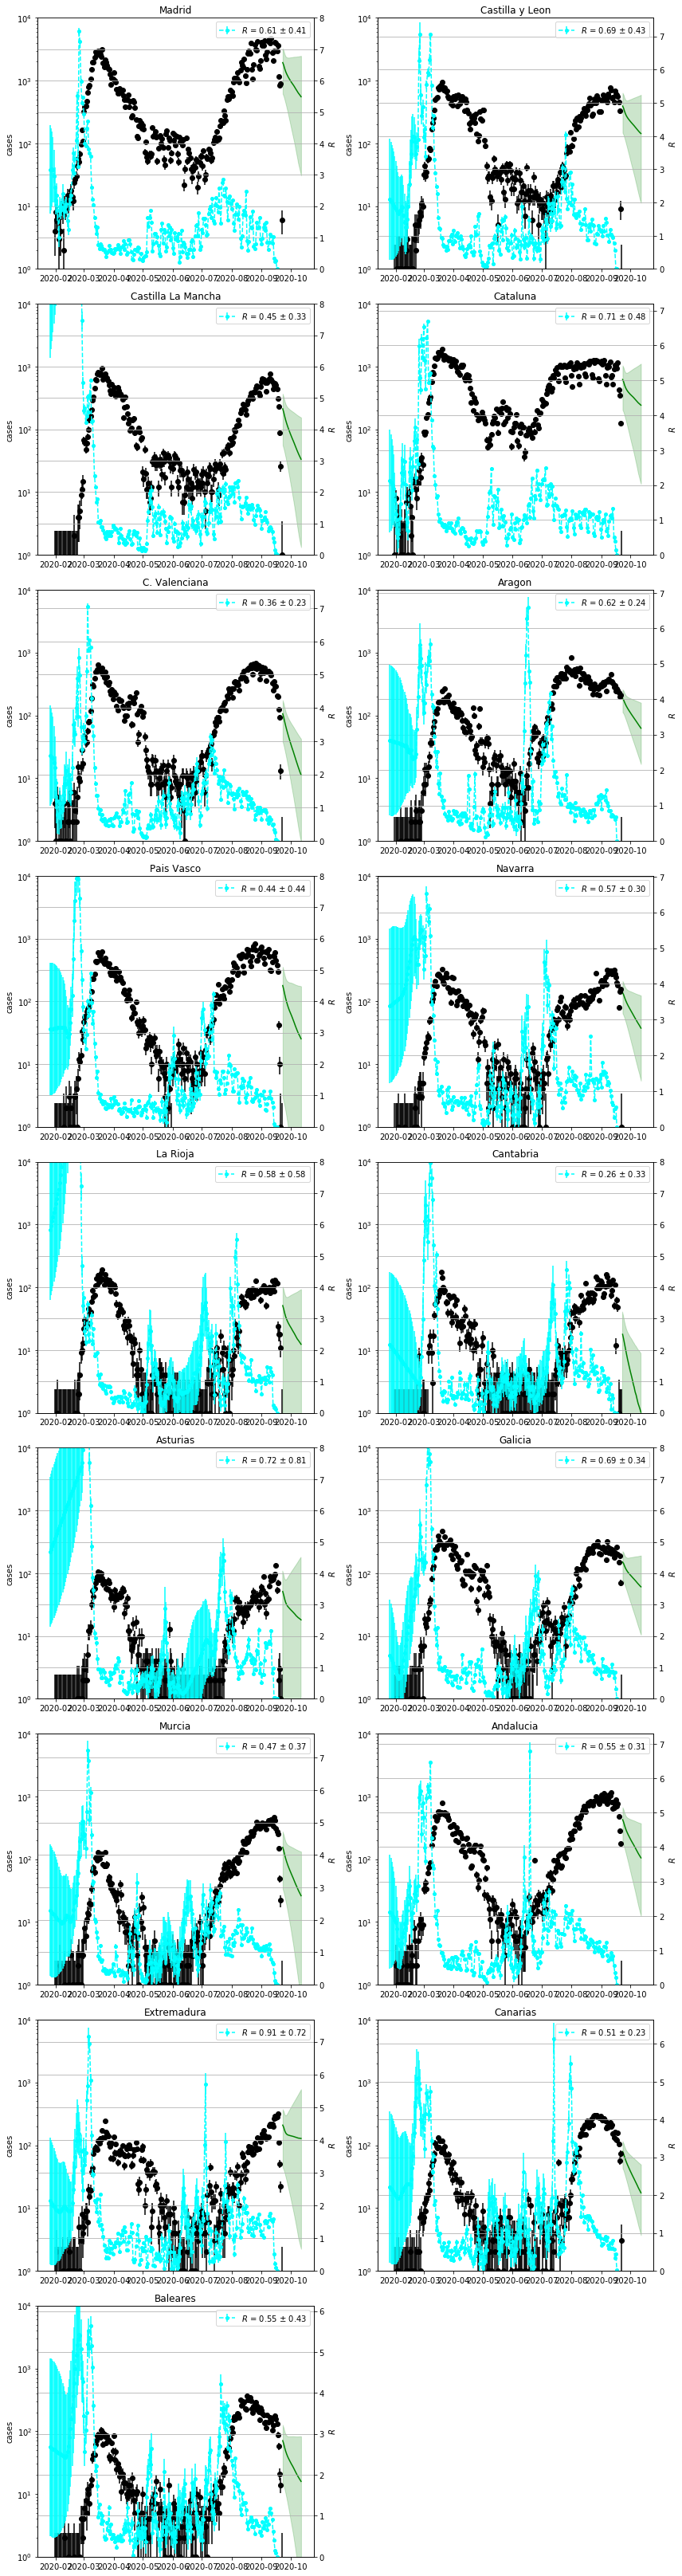

In [13]:
plt_kfs_cases_ccaa(ncols = 2)